In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

RAW_DF   = 0
COUNT_DF = 1
# parsplice hard codes the ranks, so we can pretty print the names
rank_names = {"00": "Splicer", "01": "Worker", "02": "PersistentDB", "03": "InMemoryDB", "04": "WorkManager", -1: "all ranks"}

from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
 if (code_show){$('div.input').hide();}
 else {$('div.input').show();}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                                   

# TLDR: new input, more inmemoryDB activity, still not enough load

## Trajectory Duration (Higher y-axis is Better)

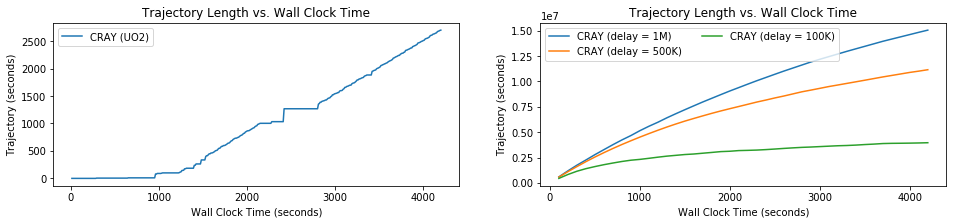

In [2]:
def plot_times(ax, label, results):
    df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label)
    ax.set_ylabel("Trajectory (seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.set_title("Trajectory Length vs. Wall Clock Time")
    ax.legend(ncol=2)

_, ax = plt.subplots(1, 2, figsize=(16, 3))
d = "../experiments/baseline-trinitite/"
ax[0].set_title("UO2 Input")
plot_times(ax[0], "CRAY (UO2)", d+"uo2")
ax[1].set_title("Nanoparticle Growth Input")
plot_times(ax[1], "CRAY (delay = 1M)",   d+"nano/delay1M")
plot_times(ax[1], "CRAY (delay = 500K)", d+"nano/delay500K")
plot_times(ax[1], "CRAY (delay = 100K)", d+"nano/delay100K")

Comparing the new nanoparticle growth simulation to the UO2 simulation:
1. Trajectory length is 2 orders of magnitude larger
2. Delay reduces trajectory length

Danny says:
> In this case, the particle is growing, so the calculation becomes progressively more expensive, hence the curving down of the simulation time vs wall clock time in the times.out.

> With this setup, the beginning of the run will be boring because small particles are quite stable, so not many transitions will occur and you won't be hitting the database much. So, the workers are indeed doing a lot of work, but it doesn't lead to much db access. Things will get more exciting for larger sizes. Try decreasing "Delay" by a factor of 10 (the particle will then grow 10 times faster). Things will pick up  quicker and you will see activity within your 1h running window. If you want even more action, you can decrease it by another factor of 10, but then the efficiency will become quite poor (which perhaps doesn't matter much if you only want to look at the behavior of the database).  

## Tunable Keyspace Size & Hotspots
These statistics are pulled from the "semantic performance counters" that we littered throughout the `LocalStore` module [example](https://gitlab.com/mikesevilla3/parsplice/blob/trinitite-nanoparticle-nospawn/core/LocalStore.cpp#L548). Basically, we wrapped every `put/get()` call with debug statement that dumps the key. 

In [3]:
### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `keyspace()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(job name, op, task)] => (rawDF, countDF)
#
# where `job name` is a human readable string that describes the job, `op` is the type of database operation,
# `task` is the MPI rank number, `rawDF` has keys and timestamps, and `countDF` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def keyspace(op, results, task="04"):
    # preprocess data    
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    if "uo2" in results:
        os.system("cat " + results + "/basic-psplice-* | grep Semantic > tmp/keyspace.log") # ouch!
        df = pd.read_csv("tmp/keyspace.log", names=['NULL', 'time', 'op', 'dbkey', 'key'])
    elif "nano" in results:
        tar = tarfile.open(results + "/logs/perf." + task + ".tar.gz")
        tar.extractall(path="tmp")
        tar.close()
        df = pd.read_csv("tmp/perf." + task + ".log", names=['NULL', 'time', 'op', 'dbkey', 'key'])
    else:
        print "ERROR: can't figure out input type (uo2 or nano)"
        return -1

    # transform data frame and count # of unique keys
    df = df[(df['op'] == op)]
    df_join = df.groupby('key').size()
    df_join = df_join.reset_index()
    df_join.columns=['key', 'count']
    if len(df_join) == 0: return df_join
    maxkey = df_join.loc[df_join['count'].idxmax()]
    print (op + " " + os.path.basename(results) + " task=" + task
           + ": nkeys=" + str(len(df_join['key']))
           + ", hottest key=" + str(maxkey[0])
           + " (count=" + str(maxkey[1]) + ")")
    return df, df_join


dfs = {}                                  # global data structure with parsed data
for op in ["DBMemoryPut", "DBMemoryGet"]: # parse data for these operations
    for t in ["01", "03", "04"]:          # parse data for these MPI ranks (or tasks)
        dfs[("UO2", op, -1)]       = keyspace(op, d+"uo2")
        dfs[("Delay 1M", op, t)]   = keyspace(op, d+"nano/delay1M", task=t)
        dfs[("Delay 500K", op, t)] = keyspace(op, d+"nano/delay500K", task=t)
        dfs[("Delay 100K", op, t)] = keyspace(op, d+"nano/delay100K", task=t)

DBMemoryPut uo2 task=04: nkeys=57, hottest key=15078487755110697300 (count=458)
DBMemoryPut uo2 task=04: nkeys=57, hottest key=15078487755110697300 (count=546)
DBMemoryPut delay1M task=03: nkeys=81, hottest key=10627150693849639731 (count=1)
DBMemoryPut delay500K task=03: nkeys=444, hottest key=10047642435126178895 (count=1)
DBMemoryPut delay100K task=03: nkeys=8716, hottest key=10000949668668174214 (count=1)
DBMemoryPut uo2 task=04: nkeys=57, hottest key=15078487755110697300 (count=546)
DBMemoryPut delay1M task=04: nkeys=100, hottest key=13397889897772269455 (count=106033)
DBMemoryPut delay500K task=04: nkeys=464, hottest key=14045287823504495930 (count=52932)
DBMemoryPut delay100K task=04: nkeys=8716, hottest key=7945113548248993750 (count=15627)
DBMemoryGet uo2 task=04: nkeys=57, hottest key=15078487755110697300 (count=1063)
DBMemoryGet uo2 task=04: nkeys=57, hottest key=15078487755110697300 (count=1063)
DBMemoryGet delay1M task=03: nkeys=81, hottest key=10627150693849639731 (count=

## All Activity is on Work Manager; There are Definitely Hot Keys
Where keys reside and who services requests. Recall the ParSplice architecture looks like this:
<img src="../paper/figures/pspice.png" width=400>

... where `S` is the splicer, `W`s are workers, and `WM` are work managers. Workers work together and produce one output, which is submitted to the work manager by one worker. We don't know how many workers to have per work manager, nor do we know we know if increasing the number of workers will increase database activity.

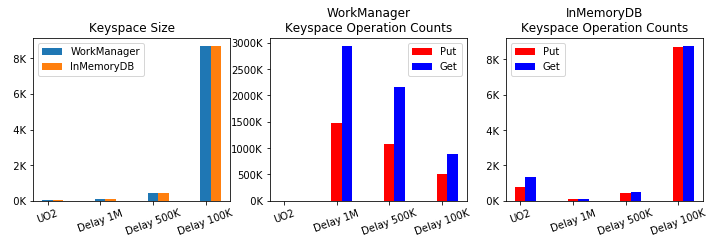

In [4]:
def plot_keyspace_size(ax, dfs, op, task, shift=0):
    # this is the order I want things graphed
    labels = [("UO2", op, -1),
              ("Delay 1M", op, task),
              ("Delay 500K", op, task),
              ("Delay 100K", op, task)]
    ax.bar(np.arange(len(labels)) + shift,
           [len(dfs[l][COUNT_DF]) for l in labels],
           width=0.2, label=rank_names[task])
    ax.set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax.get_yticks()])
    ax.set_xticklabels([0] + [l[0] for l in labels], rotation=20)
    ax.set_title("Keyspace Size")
    ax.legend()

def plot_keyspace_ops(ax, dfs, op, task, shift=0, color='red'):
    # this is the order I want things graphed
    labels = [("UO2", op, -1),
              ("Delay 1M", op, task),
              ("Delay 500K", op, task),
              ("Delay 100K", op, task)]
    ax.bar(np.arange(len(labels)) + shift,
           [np.sum(dfs[l][COUNT_DF]['count']) for l in labels],
           width=0.2, label=op.split("Memory")[1], color=color)
    ax.set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax.get_yticks()])
    ax.set_xticklabels([0] + [l[0] for l in labels], rotation=20)
    ax.set_title(rank_names[task] + "\nKeyspace Operation Counts")
    ax.legend()


fig, ax = plt.subplots(1, 3, figsize=(12, 3))
plot_keyspace_size(ax[0], dfs, "DBMemoryPut", "04")
plot_keyspace_size(ax[0], dfs, "DBMemoryPut", "03", shift=0.2)
plot_keyspace_ops(ax[1], dfs, "DBMemoryPut", "04")
plot_keyspace_ops(ax[2], dfs, "DBMemoryPut", "03")
plot_keyspace_ops(ax[1], dfs, "DBMemoryGet", "04", shift=0.2, color='blue')
plot_keyspace_ops(ax[2], dfs, "DBMemoryGet", "03", shift=0.2, color='blue')

Conclusions (corresponds to each figure):
- **Keyspace Size**: keyspace size grows with less delay 
- **WorkManager Keyspace Operation Counts**: keyspace size is the same on InMemoryDB and WorkManager
- **InMemoryDB Keyspace Operation Counts**: WorkManager services the majority of `put/get()`s

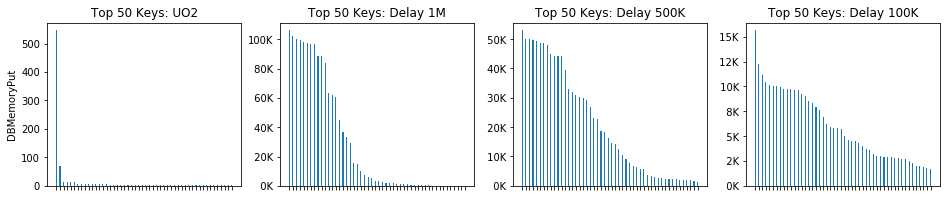

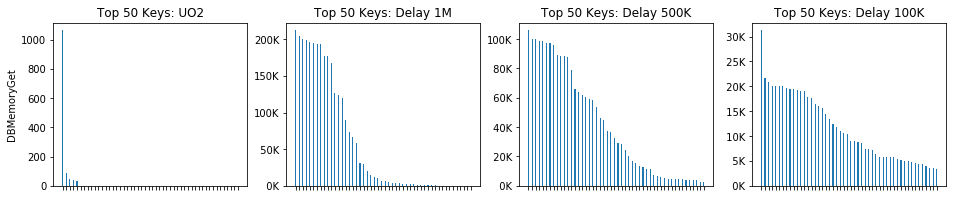

In [5]:
def plot_keyspace(ax, dfs, key, shift=0, nkeys=50):
    # parse and ingest
    dftop = dfs[key][COUNT_DF].nlargest(nkeys, 'count').head(50) # not sure why we need to do head here

    # plot it (break if we don't find any ops)
    if len(dftop) == 0: return -1
    x = np.arange(len(dftop['key']))
    ax.bar(x + shift, dftop['count'], width=0.3, label=rank_names[key[2]])

    # cleanup graphs
    ax.set_xticks(x); ax.set_xticklabels([])
    if np.max(ax.get_yticks()) > 2000:
        ax.set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax.get_yticks()])
    ax.set_title("Top " + str(nkeys) + " Keys: " + key[0])
    #ax.set_xticklabels(d['key'], rotation=90)

for op in ["DBMemoryPut", "DBMemoryGet"]:
    fig, ax = plt.subplots(1, 4, figsize=(16, 3))
    plot_keyspace(ax[0], dfs, ("UO2", op, -1))
    plot_keyspace(ax[1], dfs, ("Delay 1M", op, "04"))
    plot_keyspace(ax[2], dfs, ("Delay 500K", op, "04"))
    plot_keyspace(ax[3], dfs, ("Delay 100K", op, "04"))
    ax[0].set_ylabel(op)

Conclusions:
- **DBMemoryPut vs Get**: 2x more reads
- **From Left to Right**: Larger delays have hotter keys
- Many more hotspots than the UO2

# Temporal Locality
When keys are accessed:

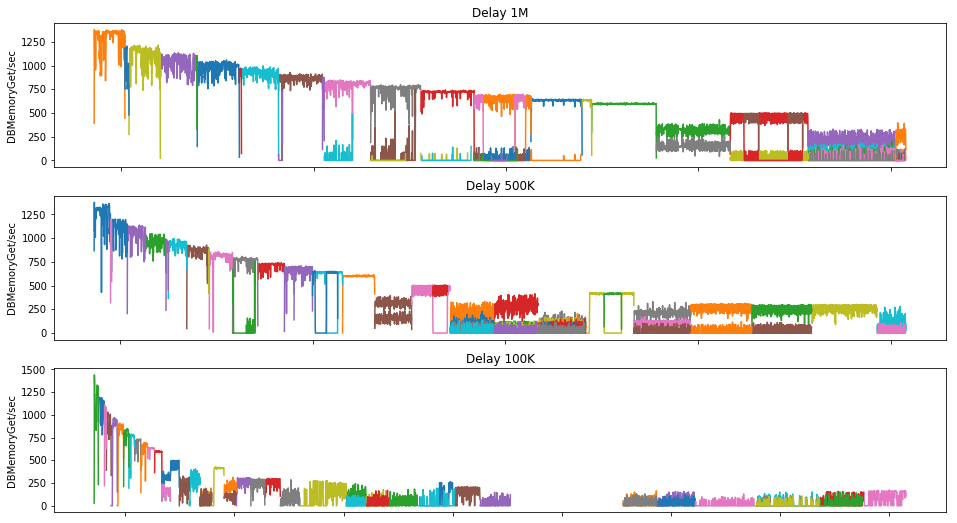

In [6]:
def plot_keytimes(ax, dfs, key_tuple, shift=0, nkeys=50):
    # parse and ingest
    dftop = dfs[key_tuple][COUNT_DF].nlargest(nkeys, 'count').head(50) # not sure why we need to do head here
    #print dftop['key']

    # transform data frame and filter out keys
    raw = dfs[key_tuple][RAW_DF]

    for key in dftop['key']:
        d = raw[(raw['key'] == key)]
        d = d.groupby('time').size()
        d = d.reset_index()
        d.columns=['time', 'count']

        if len(d) == 0: continue
        first    = np.min(d['time'])
        last     = np.max(d['time'])
        ts_range = last - first + 1
        x = np.arange(ts_range) + first
        y = np.zeros(ts_range)
        for k, v in d.iterrows():
            y[v['time'] - first] = v['count']
        ax.plot(x, y, label=key)
        #return 

    # cleanup graphs
    ax.set_xticklabels([])
    ax.set_title(key_tuple[0])
    ax.set_ylabel(key_tuple[1] + "/sec")

fig, ax = plt.subplots(3, 1, figsize=(16, 9))
plot_keytimes(ax[0], dfs, ("Delay 1M", "DBMemoryGet", "04"))
plot_keytimes(ax[1], dfs, ("Delay 500K", "DBMemoryGet", "04"))
plot_keytimes(ax[2], dfs, ("Delay 100K", "DBMemoryGet", "04"))

Conclusions: 
- keys are never re-accessed
- delay reduces the load on in-memoryDB
- Some keys are "colder" than others

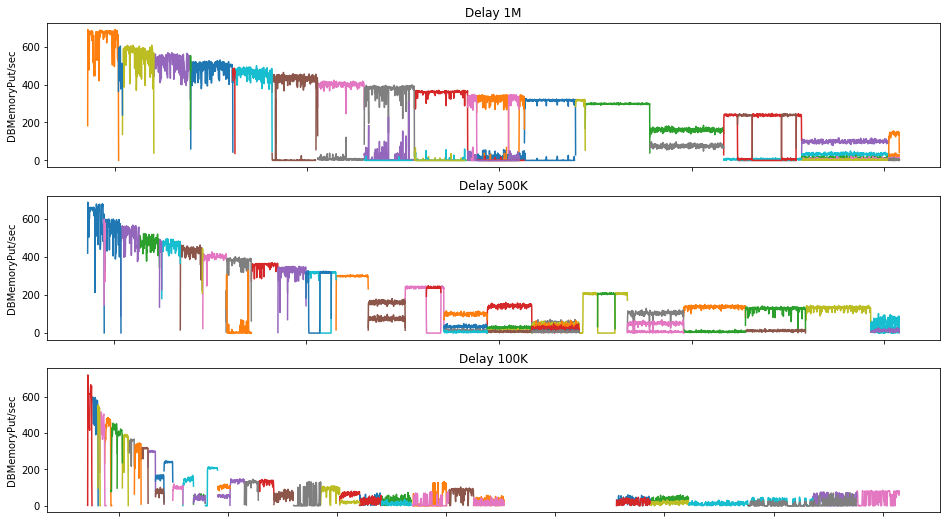

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9))
plot_keytimes(ax[0], dfs, ("Delay 1M", "DBMemoryPut", "04"))
plot_keytimes(ax[1], dfs, ("Delay 500K", "DBMemoryPut", "04"))
plot_keytimes(ax[2], dfs, ("Delay 100K", "DBMemoryPut", "04"))

Conclusions:
- this is not as exciting as `get`
- WHY IS IT PUTTING THE SAME KEY?

Next Steps: overload the work manager
1. Crank down the delay. This will make the keyspace larger and will cause the MRU to fall
2. Artificially limit the size of the MRU

Other Steps: show potential for replication
1. Show keyspace on work managers; replicate duplicates
2. Ask Danny about "sweet spot" for #WMs, #Ws/WM, #Ranks per W; from Rich:

> This would be more to understand how real runs would be done in the ideal case. I’m not sure how much Danny has explored this, though. My current understanding is that #WMs = #LAMMPS engines in parallel. #Ws and #Ranks per W controls how parallel a single LAMMPS engine instance can be. I think the Summer School students might have done some work in this area if I remember right. I’ll try to dig up info on what they did.